In [1]:
import pandas as pd
import numpy as np

In [2]:
df_ed = pd.read_csv('big_data/event_data_train.csv')
df_sd = pd.read_csv('big_data/submissions_data_train.csv')

In [3]:
df_ed['date'] = pd.to_datetime(df_ed.timestamp, unit='s')
df_ed['day'] = df_ed.date.dt.date

df_sd['date'] = pd.to_datetime(df_sd.timestamp, unit='s')
df_sd['day'] = df_sd.date.dt.date

In [4]:
df_ed.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [5]:
df_sd.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


<Axes: xlabel='day'>

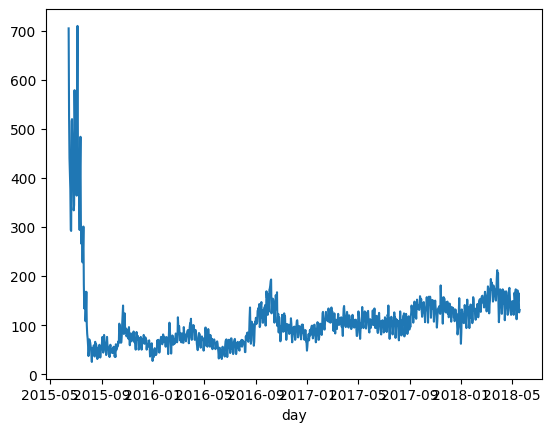

In [6]:
df_ed.groupby('day').user_id.nunique().plot()

In [7]:
users_events_data = df_ed.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [8]:
user_scores = df_sd.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [9]:
user_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [10]:
gap_data = df_ed[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id','day']) \
    .groupby('user_id').timestamp.apply(list).apply(np.diff).values

In [11]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [12]:
import seaborn as sns

In [13]:
gap_data = gap_data / (60*60*24)

<Axes: >

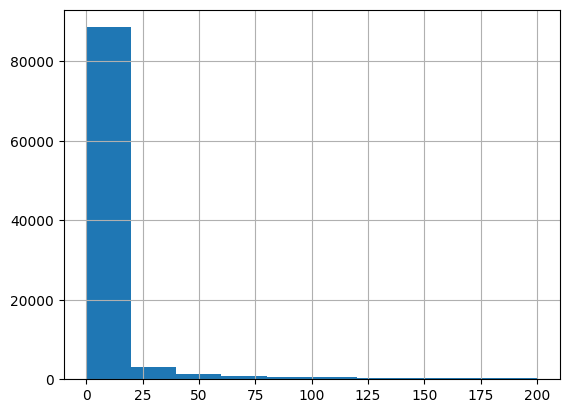

In [14]:
gap_data[gap_data < 200].hist()

In [15]:
gap_data.quantile(0.90)

18.325995370370403

In [16]:
df_ed.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [17]:
60*60*24*30

2592000

In [18]:
now = 1526772811
drop_out_threshold = 2592000

In [19]:
user_data = df_ed.groupby('user_id', as_index=False).aggregate(last_ts=('timestamp', 'max'))

In [20]:
user_data['is_gone_user'] = (now - user_data.last_ts) > drop_out_threshold

In [21]:
user_data.head()

,user_id,last_ts,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [22]:
user_data = user_data.merge(user_scores, on='user_id', how='outer').fillna(0)

In [23]:
user_data.head()

,user_id,last_ts,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [24]:
user_data = user_data.merge(users_events_data, on='user_id', how='outer').fillna(0)

In [25]:
user_data.head()

,user_id,last_ts,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [26]:
users_days = df_ed.groupby('user_id', as_index=False).day.nunique()

In [27]:
user_data = user_data.merge(users_days, on='user_id', how='outer').fillna(0)

In [28]:
user_data['passed_course'] = user_data.passed > 170

In [29]:
user_data.passed_course.value_counts()

False    17809
True      1425
Name: passed_course, dtype: int64

In [30]:
user_data.head()

,user_id,last_ts,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [31]:
user_data[user_data.passed_course].day.median()

20.0

<Axes: >

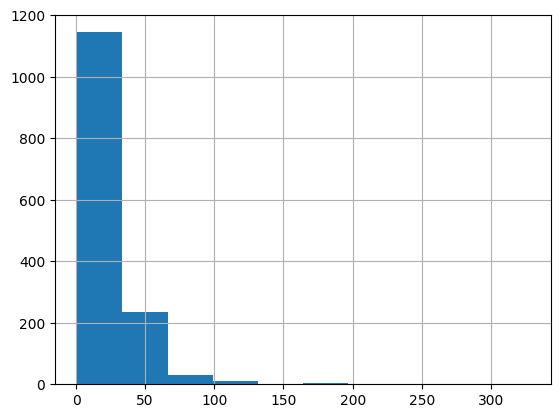

In [32]:
user_data[user_data.passed_course].day.hist()

In [33]:
user_min_time = df_ed.groupby('user_id', as_index=False) \
                .aggregate({'timestamp':'min'}) \
                .rename({'timestamp':'min_timestamp'}, axis=1)

In [34]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [35]:
user_data = user_data.merge(user_min_time, how='outer', on='user_id')

In [36]:
user_data.head()

,user_id,last_ts,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [37]:
from datetime import timedelta

In [38]:
event_data_train = df_ed.merge(user_min_time, on='user_id', how='outer')

In [39]:
event_data_train = event_data_train[event_data_train.timestamp <= (event_data_train.min_timestamp + int(timedelta(days=3).total_seconds()))]

In [40]:
event_data_train.shape

(1014985, 7)

In [41]:
event_data_train.groupby('user_id').day.nunique().max()

4

In [42]:
event_data_train.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848


In [43]:
submission_data_train = df_sd.merge(user_min_time)

In [44]:
submission_data_train.min_timestamp = submission_data_train.min_timestamp + int(timedelta(days=3).total_seconds())

In [45]:
submission_data_train = submission_data_train[submission_data_train.timestamp <= submission_data_train.min_timestamp]

In [46]:
submission_data_train.groupby('user_id').day.nunique().max()

4

In [47]:
submission_data_train.shape

(135599, 7)

In [48]:
df_sd.shape

(509104, 6)

In [49]:
X = submission_data_train.groupby('user_id', as_index=False) \
    .agg(days=('day','nunique'), steps_tried=('step_id','nunique'))

In [50]:
X = X.merge(submission_data_train.pivot_table(index='user_id', 
                                  columns='submission_status', 
                                  values='step_id', 
                                  aggfunc='count', 
                                  fill_value=0).reset_index(), on='user_id', how='outer')

In [51]:
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


In [52]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [53]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [54]:
X.shape

(8913, 6)

In [55]:
X = X.merge(event_data_train.pivot_table(index='user_id', 
                                  columns='action', 
                                  values='step_id', 
                                  aggfunc='count', 
                                  fill_value=0).reset_index()[['user_id', 'viewed']], on='user_id', how='outer')

In [56]:
X.shape

(19234, 7)

In [57]:
X = X.fillna(0)

In [58]:
X = X.merge(user_data[['user_id', 'passed_course', 'is_gone_user']], on='user_id', how='outer')

In [59]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [60]:
X.shape

(17985, 9)

In [61]:
y = X.passed_course

In [62]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

In [63]:
X = X.set_index('user_id')

In [64]:
X

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...
26774,0.0,0.0,0.0,0.0,0.00,1
26781,0.0,0.0,0.0,0.0,0.00,6
26788,0.0,0.0,0.0,0.0,0.00,1


In [65]:
y = y.map(int)

In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [67]:
clf = DecisionTreeClassifier()

In [68]:
parametrs = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 11), 
    'min_samples_split': range(2, 11), 
    'min_samples_leaf': range(1,11)
}

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [70]:
grid_search_clf = GridSearchCV(clf, parametrs, cv=5)

In [71]:
grid_search_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 11),
                         'min_samples_leaf': range(1, 11),
                         'min_samples_split': range(2, 11)})

In [72]:
grid_search_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 10,
 'min_samples_split': 4}

In [73]:
best_tree = grid_search_clf.best_estimator_

In [74]:
y_pred = best_tree.predict(X_test)

In [75]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay

In [76]:
from sklearn.metrics import precision_recall_fscore_support

In [77]:
precision_recall_fscore_support(y_test, y_pred, average='binary')

(0.5, 0.10826210826210826, 0.17798594847775176, None)

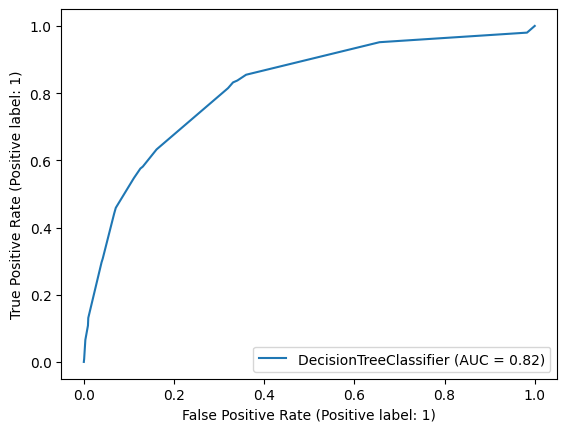

In [78]:
svc_disp = RocCurveDisplay.from_estimator(grid_search_clf.best_estimator_, X_test, y_test)

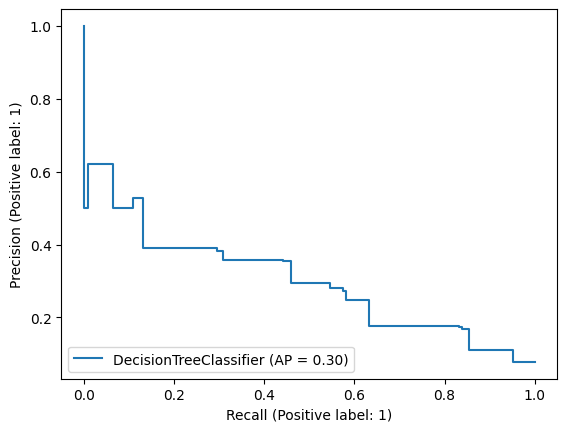

In [79]:
svc_disp1 = PrecisionRecallDisplay.from_estimator(grid_search_clf.best_estimator_, X_test, y_test)

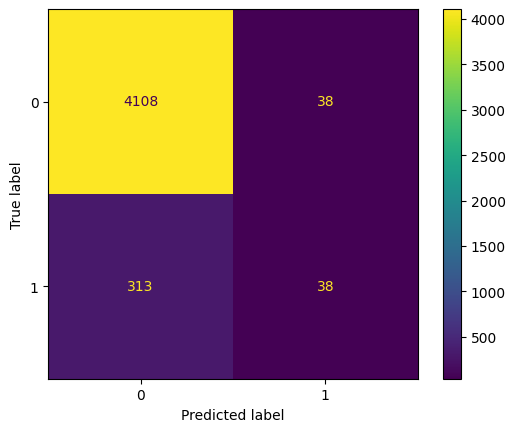

In [80]:
svc_disp2 = ConfusionMatrixDisplay.from_estimator(grid_search_clf.best_estimator_, X_test, y_test)

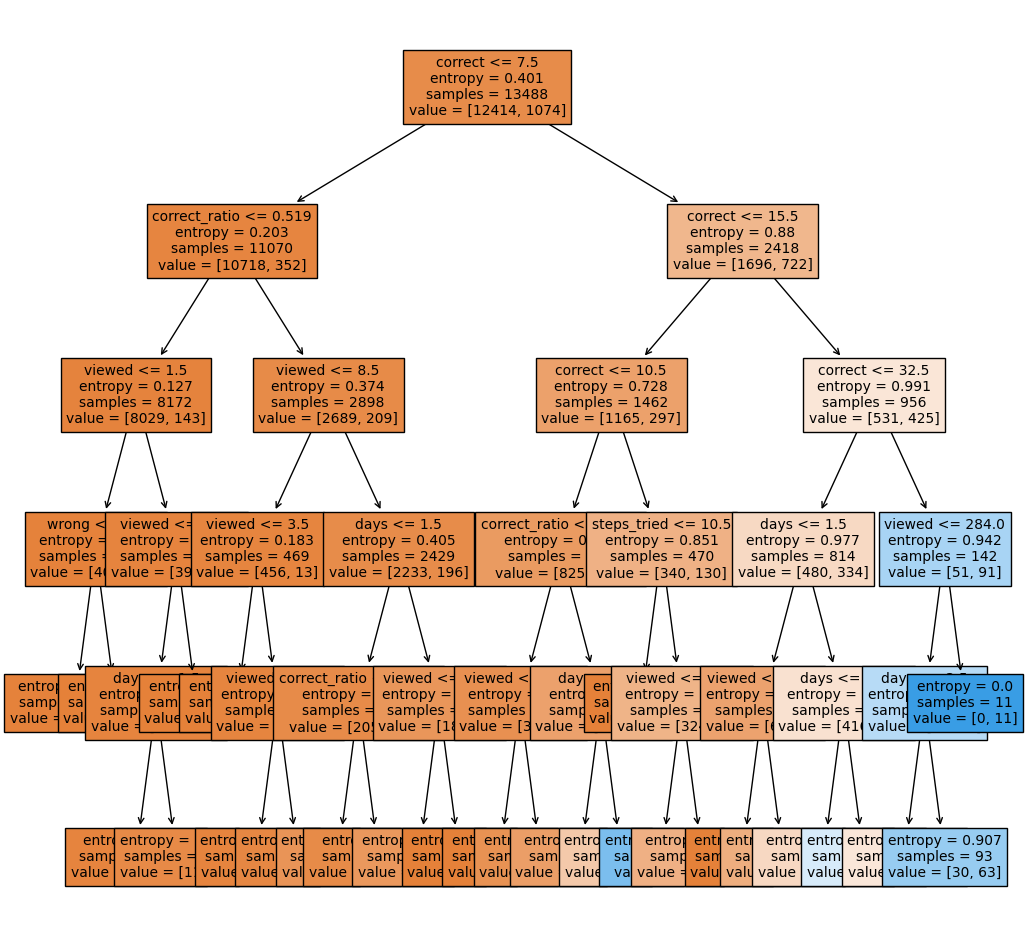

In [81]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
plot_tree(best_tree, filled=True, feature_names=X.columns, fontsize=10)
plt.show()

In [82]:
from sklearn.ensemble import RandomForestClassifier

In [83]:
clf_rf = RandomForestClassifier()

In [94]:
params = {'n_estimators':[30, 40, 50], 'max_depth':range(2, 10)}

In [95]:
grid_search_cv_clf = GridSearchCV(clf_rf, params, cv=5)

In [96]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(2, 10),
                         'n_estimators': [30, 40, 50]})

In [97]:
grid_search_cv_clf.best_params_

{'max_depth': 4, 'n_estimators': 30}

In [98]:
y_pred = grid_search_cv_clf.best_estimator_.predict(X_test)

In [99]:
precision_recall_fscore_support(y_test, y_pred, average='binary')

(0.6341463414634146, 0.07407407407407407, 0.1326530612244898, None)

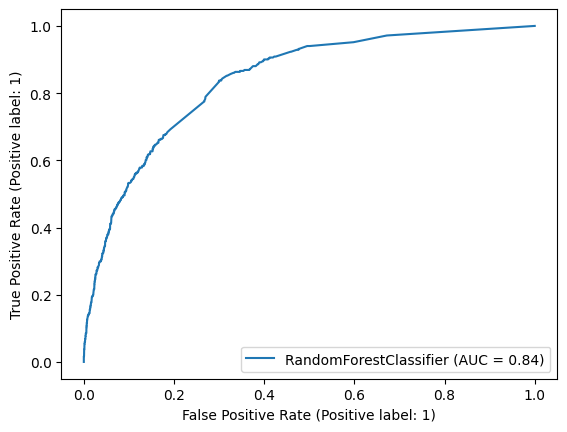

In [100]:
svc_disp = RocCurveDisplay.from_estimator(grid_search_cv_clf.best_estimator_, X_test, y_test)

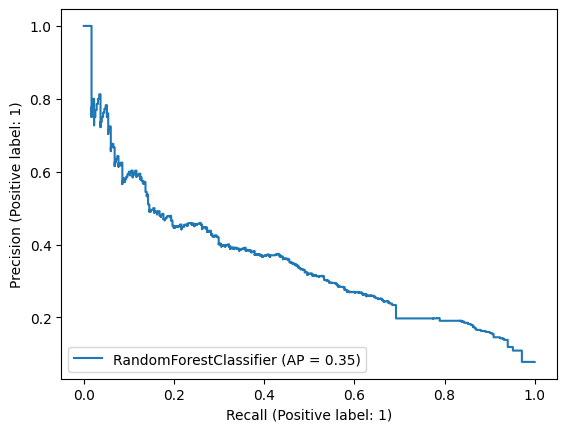

In [101]:
svc_disp1 = PrecisionRecallDisplay.from_estimator(grid_search_cv_clf.best_estimator_, X_test, y_test)

In [103]:
fi = grid_search_cv_clf.best_estimator_.feature_importances_

In [104]:
fi_df = pd.DataFrame({'features': list(X_train), 'fi': fi})

In [106]:
fi_df

,features,fi
0,days,0.152194
1,steps_tried,0.292892
2,correct,0.347086
3,wrong,0.013500
4,correct_ratio,0.049380
5,viewed,0.144947
